<a href="https://colab.research.google.com/github/yustiks/video_compression/blob/main/CompressAI_Inference_Demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<!-- Copyright 2020 InterDigital Communications, Inc.

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

    http://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License. -->

In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive


In [11]:
folder_name = '/MyDrive/Deelvin_docs/Image_compression/data_576_768/'

# CompressAI inference demo

In [3]:
import math
import io
import torch
from torchvision import transforms
import numpy as np

from PIL import Image

import matplotlib.pyplot as plt

In [4]:
!pip install compressai

     |████████████████████████████████| 243 kB 5.5 MB/s 


In [5]:
from pytorch_msssim import ms_ssim

In [6]:
from compressai.zoo import bmshj2018_factorized

In [7]:
from ipywidgets import interact, widgets

## Global settings

In [8]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

## Load a pretrained model

In [9]:
net = bmshj2018_factorized(quality=2, pretrained=True).eval().to(device)

Downloading: "https://compressai.s3.amazonaws.com/models/v1/bmshj2018-factorized-prior-2-87279a02.pth.tar" to /root/.cache/torch/hub/checkpoints/bmshj2018-factorized-prior-2-87279a02.pth.tar


  0%|          | 0.00/11.5M [00:00<?, ?B/s]

In [10]:
print(f'Parameters: {sum(p.numel() for p in net.parameters())}')

Parameters: 2998147


## 1. Inference

### Load image and convert to 4D float tensor

First, we need to load an RGB image and convert it to a 4D floating point tensor, as the network expectes an input tensor of size: `(batch_size, 3, height, width)`.

In [13]:
!mkdir data

In [18]:
mywidth = 768
folder_name = '/content/drive/MyDrive/Deelvin_docs/image_compression/data_576_768/'
for i in range(1, 11):
  print(folder_name + str(i) + '.jpg')
  img = Image.open(folder_name + str(i) + '.jpg').convert('RGB')
#  img = img.rotate(180)
  wpercent = (mywidth/float(img.size[0]))
  hsize = int((float(img.size[1])*float(wpercent)))
  img = img.resize((mywidth,hsize), Image.ANTIALIAS)
  img.save('data/' + str(i) + '.jpg')
  w, h = img.size
  print(w, ';', h)

/content/drive/MyDrive/Deelvin_docs/image_compression/data_576_768/1.jpg
768 ; 576
/content/drive/MyDrive/Deelvin_docs/image_compression/data_576_768/2.jpg
768 ; 576
/content/drive/MyDrive/Deelvin_docs/image_compression/data_576_768/3.jpg
768 ; 576
/content/drive/MyDrive/Deelvin_docs/image_compression/data_576_768/4.jpg
768 ; 576
/content/drive/MyDrive/Deelvin_docs/image_compression/data_576_768/5.jpg
768 ; 576
/content/drive/MyDrive/Deelvin_docs/image_compression/data_576_768/6.jpg
768 ; 576
/content/drive/MyDrive/Deelvin_docs/image_compression/data_576_768/7.jpg
768 ; 576
/content/drive/MyDrive/Deelvin_docs/image_compression/data_576_768/8.jpg
768 ; 576
/content/drive/MyDrive/Deelvin_docs/image_compression/data_576_768/9.jpg
768 ; 576
/content/drive/MyDrive/Deelvin_docs/image_compression/data_576_768/10.jpg
768 ; 576


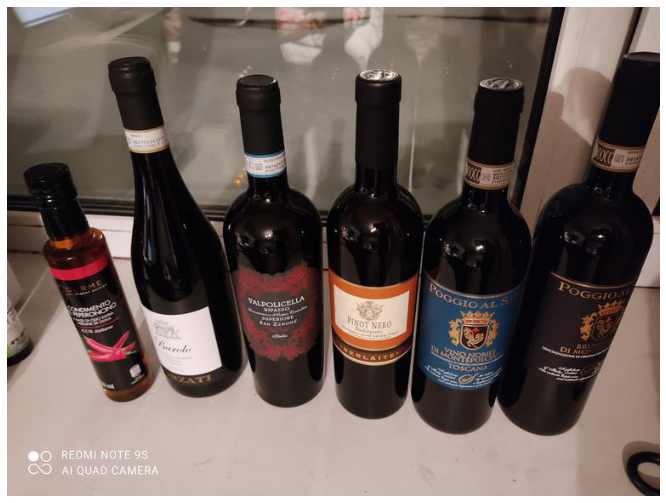

In [19]:
%matplotlib inline
plt.figure(figsize=(12, 9))
plt.axis('off')
plt.imshow(img)
plt.show()

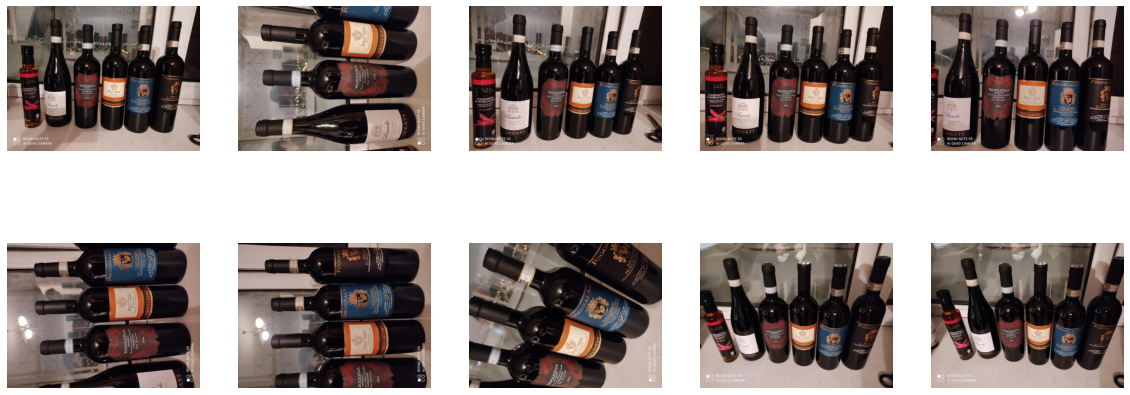

In [33]:
import numpy as np


fig = plt.figure(figsize=(20, 8))
columns = 5
rows = 2
for i in range(1, columns*rows +1):
    img = Image.open('data/' + str(i) + '.jpg').convert('RGB')
    if i==1 or i==3 or i==4 or i==5:
      img = img.rotate(180)
    fig.add_subplot(rows, columns, i)
    plt.axis('off')
    plt.imshow(img)

plt.savefig('figure.png')

### Run the network

In [22]:
for i in range(1, 11):
  img = Image.open('data/' + str(i) + '.jpg').convert('RGB')
  x = transforms.ToTensor()(img).unsqueeze(0).to(device)
  with torch.no_grad():
    out_net = net.forward(x)
  out_net['x_hat'].clamp_(0, 1)
  rec_net = transforms.ToPILImage()(out_net['x_hat'].squeeze().cpu())
  diff = torch.mean((out_net['x_hat'] - x).abs(), axis=1).squeeze().cpu()
  %matplotlib inline
  #print(f'PSNR: {compute_psnr(x, out_net["x_hat"]):.2f}dB')
  #print(f'MS-SSIM: {compute_msssim(x, out_net["x_hat"]):.4f}')
  print(f'Bit-rate: {compute_bpp(out_net):.3f} bpp')

Bit-rate: 0.164 bpp
Bit-rate: 0.147 bpp
Bit-rate: 0.164 bpp
Bit-rate: 0.166 bpp
Bit-rate: 0.162 bpp
Bit-rate: 0.149 bpp
Bit-rate: 0.155 bpp
Bit-rate: 0.155 bpp
Bit-rate: 0.138 bpp
Bit-rate: 0.147 bpp


In [ ]:
out_net['x_hat'].size()

torch.Size([1, 3, 576, 768])

In [ ]:
with torch.no_grad():
    out_net = net.forward(x)
out_net['x_hat'].clamp_(0, 1)
print(out_net.keys())

dict_keys(['x_hat', 'likelihoods'])


We obtain a dictionary with the decoded/reconstructed image tensor `x_hat` and the latent(s) likelihoods.

### Visualize result

Convert the Tensor back to a 2D Pillow image:

In [ ]:
rec_net = transforms.ToPILImage()(out_net['x_hat'].squeeze().cpu())

In [ ]:
diff = torch.mean((out_net['x_hat'] - x).abs(), axis=1).squeeze().cpu()

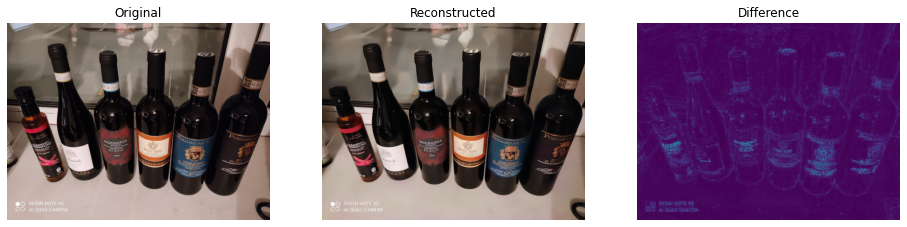

In [ ]:
%matplotlib inline
fix, axes = plt.subplots(1, 3, figsize=(16, 12))
for ax in axes:
    ax.axis('off')
    
axes[0].imshow(img)
axes[0].title.set_text('Original')

axes[1].imshow(rec_net)
axes[1].title.set_text('Reconstructed')

axes[2].imshow(diff, cmap='viridis')
axes[2].title.set_text('Difference')

plt.show()

### Compute metrics

Now, let's compute some common metrics...

In [21]:
def compute_psnr(a, b):
    mse = torch.mean((a - b)**2).item()
    return -10 * math.log10(mse)

def compute_msssim(a, b):
    return ms_ssim(a, b, data_range=1.).item()

def compute_bpp(out_net):
    size = out_net['x_hat'].size()
    num_pixels = size[0] * size[2] * size[3]
    return sum(torch.log(likelihoods).sum() / (-math.log(2) * num_pixels)
              for likelihoods in out_net['likelihoods'].values()).item()

In [ ]:
print(f'PSNR: {compute_psnr(x, out_net["x_hat"]):.2f}dB')
print(f'MS-SSIM: {compute_msssim(x, out_net["x_hat"]):.4f}')
print(f'Bit-rate: {compute_bpp(out_net):.3f} bpp')

PSNR: 27.08dB
MS-SSIM: 0.9484
Bit-rate: 0.214 bpp


## 2. Comparison to classical codecs

Let's perform some comparison against JPEG and WebP as they are included in the Pillow library.

In [ ]:
def pillow_encode(img, fmt='jpeg', quality=10):
    tmp = io.BytesIO()
    img.save(tmp, format=fmt, quality=quality)
    tmp.seek(0)
    filesize = tmp.getbuffer().nbytes
    bpp = filesize * float(8) / (img.size[0] * img.size[1])
    rec = Image.open(tmp)
    return rec, bpp

In [ ]:
from functools import partial

In [ ]:
def find_closest_bpp(target, img, fmt='jpeg'):
    lower = 0
    upper = 100
    prev_mid = upper
    for i in range(10):
        mid = (upper - lower) / 2 + lower
        if int(mid) == int(prev_mid):
            break
        rec, bpp = pillow_encode(img, fmt=fmt, quality=int(mid))
        if bpp > target:
            upper = mid - 1
        else:
            lower = mid
    return rec, bpp

def find_closest_psnr(target, img, fmt='jpeg'):
    lower = 0
    upper = 100
    prev_mid = upper
    
    def _psnr(a, b):
        a = np.asarray(a).astype(np.float32)
        b = np.asarray(b).astype(np.float32)
        mse = np.mean(np.square(a - b))
        return 20*math.log10(255.) -10. * math.log10(mse)
    
    for i in range(10):
        mid = (upper - lower) / 2 + lower
        if int(mid) == int(prev_mid):
            break
        prev_mid = mid
        rec, bpp = pillow_encode(img, fmt=fmt, quality=int(mid))
        psnr_val = _psnr(rec, img)
        if psnr_val > target:
            upper = mid - 1
        else:
            lower = mid
    return rec, bpp, psnr_val

def find_closest_msssim(target, img, fmt='jpeg'):
    lower = 0
    upper = 100
    prev_mid = upper
    
    def _mssim(a, b):
        a = torch.from_numpy(np.asarray(a).astype(np.float32)).permute(2, 0, 1).unsqueeze(0)
        b = torch.from_numpy(np.asarray(b).astype(np.float32)).permute(2, 0, 1).unsqueeze(0)
        return ms_ssim(a, b, data_range=255.).item()

    for i in range(10):
        mid = (upper - lower) / 2 + lower
        if int(mid) == int(prev_mid):
            break
        prev_mid = mid
        rec, bpp = pillow_encode(img, fmt=fmt, quality=int(mid))
        msssim_val = _mssim(rec, img)
        if msssim_val > target:
            upper = mid - 1
        else:
            lower = mid
    return rec, bpp, msssim_val

### 2.1 Quality comparison at similar bit-rate

In [ ]:
target_bpp = compute_bpp(out_net)
rec_jpeg, bpp_jpeg = find_closest_bpp(target_bpp, img)
rec_webp, bpp_webp = find_closest_bpp(target_bpp, img, fmt='webp')

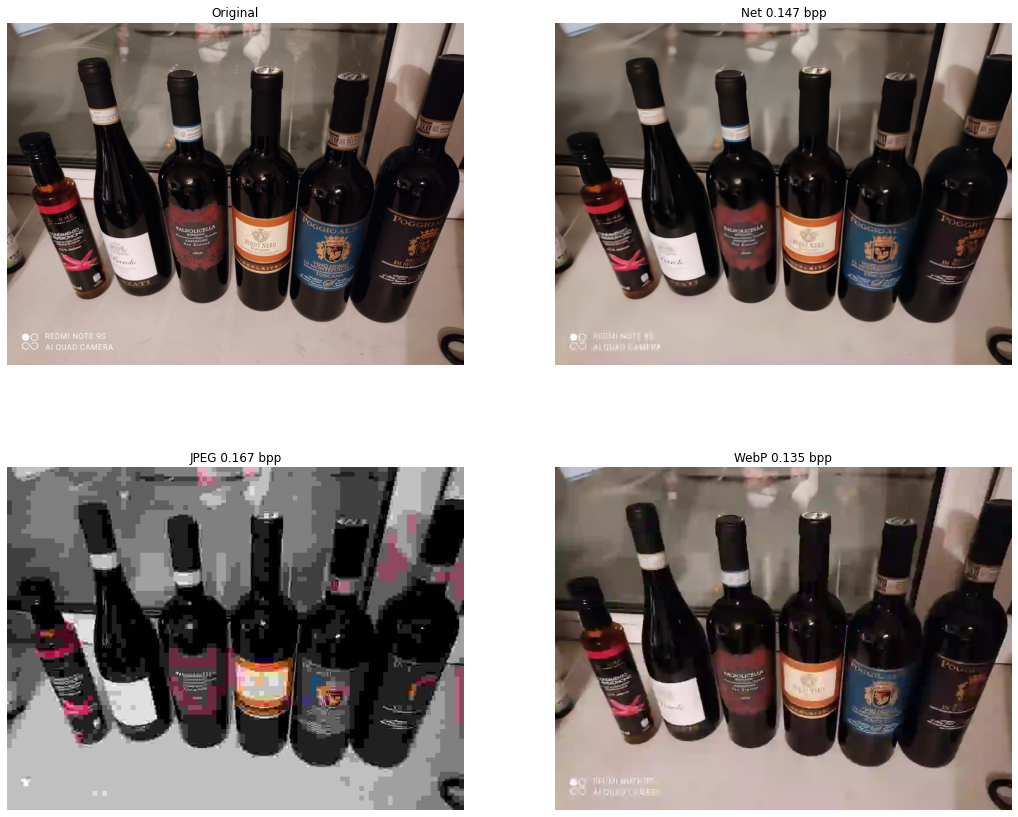

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(18, 15))
for ax in axes.ravel():
    ax.axis('off')

fig.title = 'yolo'
axes[0][0].imshow(img)
axes[0][0].title.set_text('Original')
axes[0][1].imshow(rec_net)
axes[0][1].title.set_text(f'Net {target_bpp:.3f} bpp')
axes[1][0].imshow(rec_jpeg)
axes[1][0].title.set_text(f'JPEG {bpp_jpeg:.3f} bpp')
axes[1][1].imshow(rec_webp)
axes[1][1].title.set_text(f'WebP {bpp_webp:.3f} bpp')

plt.show()

### 2.2 Bit-rate comparison at similar PSNR

In [ ]:
target_psnr = compute_psnr(x, out_net["x_hat"])
rec_jpeg, bpp_jpeg, psnr_jpeg = find_closest_psnr(target_psnr, img)
rec_webp, bpp_webp, psnr_webp = find_closest_psnr(target_psnr, img, fmt='webp')

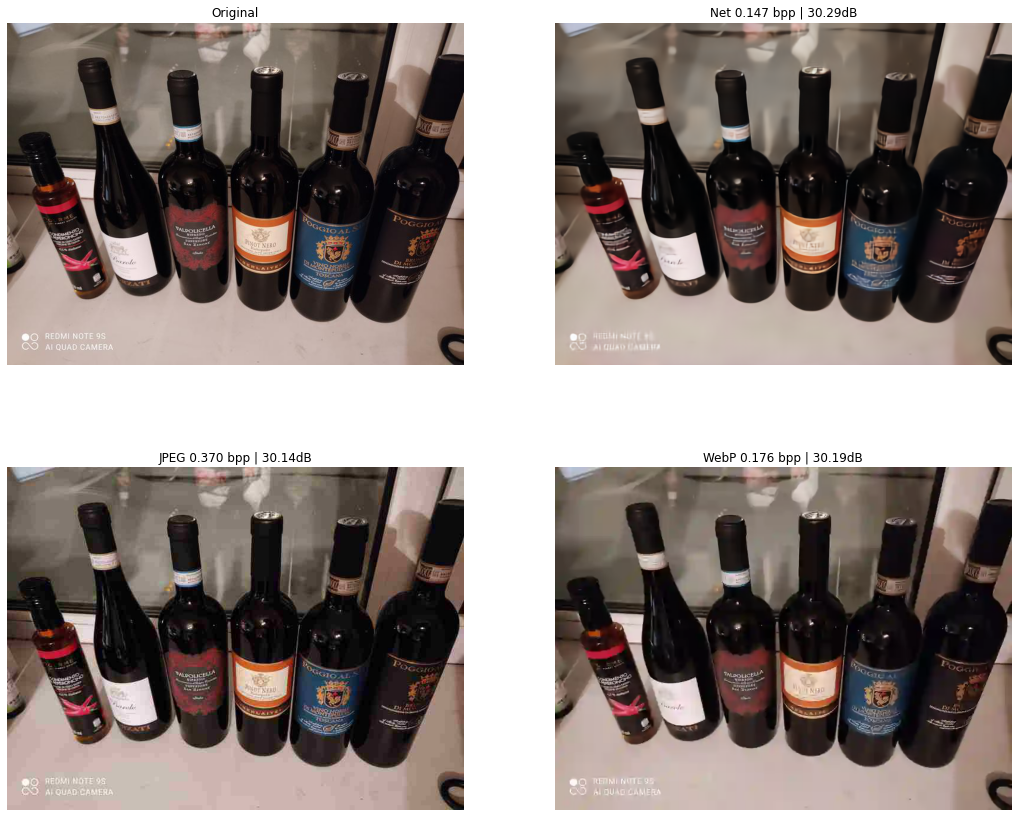

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(18, 15))
for ax in axes.ravel():
    ax.axis('off')
    
axes[0][0].imshow(img)
axes[0][0].title.set_text('Original')
axes[0][1].imshow(rec_net)
axes[0][1].title.set_text(f'Net {target_bpp:.3f} bpp | {target_psnr:.2f}dB')
axes[1][0].imshow(rec_jpeg)
axes[1][0].title.set_text(f'JPEG {bpp_jpeg:.3f} bpp | {psnr_jpeg:.2f}dB')
axes[1][1].imshow(rec_webp)
axes[1][1].title.set_text(f'WebP {bpp_webp:.3f} bpp | {psnr_webp:.2f}dB')

plt.show()

### 2.3) Bit-rate comparison at similar MS-SSIM

In [ ]:
target_msssim = compute_msssim(x, out_net["x_hat"])
rec_jpeg, bpp_jpeg, msssim_jpeg = find_closest_msssim(target_msssim, img)
rec_webp, bpp_webp, msssim_webp = find_closest_msssim(target_msssim, img, fmt='webp')

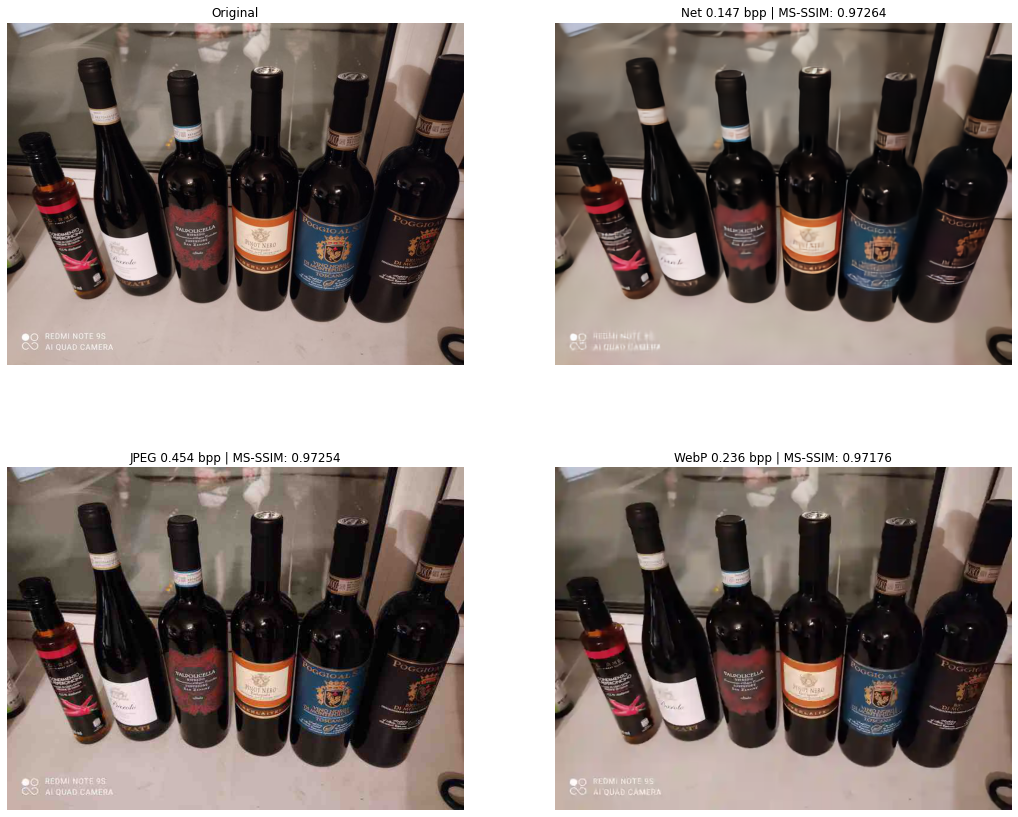

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(18, 15))
for ax in axes.ravel():
    ax.axis('off')
    
axes[0][0].imshow(img)
axes[0][0].title.set_text('Original')
axes[0][1].imshow(rec_net)
axes[0][1].title.set_text(f'Net {target_bpp:.3f} bpp | MS-SSIM: {target_msssim:.5f}')
axes[1][0].imshow(rec_jpeg)
axes[1][0].title.set_text(f'JPEG {bpp_jpeg:.3f} bpp | MS-SSIM: {msssim_jpeg:.5f}')
axes[1][1].imshow(rec_webp)
axes[1][1].title.set_text(f'WebP {bpp_webp:.3f} bpp | MS-SSIM: {msssim_webp:.5f}')

plt.show()

## 3. Latent visualization

### Per-latent bit-rate results

In [ ]:
def detailed_bpp(out):
    size = out['x_hat'].size()
    num_pixels = size[0] * size[2] * size[3]
    for name, values in out_net['likelihoods'].items():
        bpp_val = torch.log(values).sum() / (-math.log(2) * num_pixels)
        print(f'- "{name}" latent bit-rate: {bpp_val:.3f} bpp')
               
detailed_bpp(out_net)

- "y" latent bit-rate: 0.147 bpp


In [ ]:
with torch.no_grad():
    y = net.g_a(x)
    y_hat, y_likelihoods = net.entropy_bottleneck(y)
    print(y.size(), y_likelihoods.size())

torch.Size([1, 192, 36, 48]) torch.Size([1, 192, 36, 48])


## Per channel estimated bit-rate

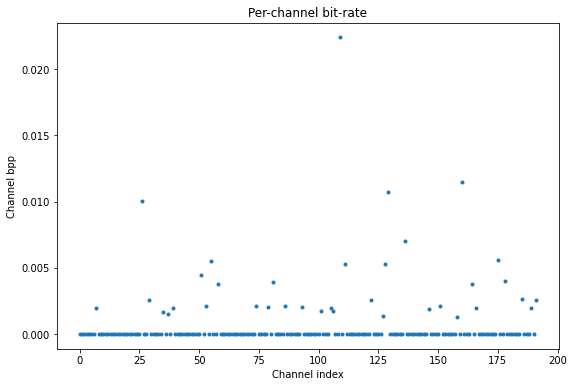

In [ ]:
%matplotlib inline
num_pixels = x.size(2) * x.size(3)

channel_bpps = [torch.log(y_likelihoods[0, c]).sum().item() / (-math.log(2) * num_pixels)
                for c in range(y.size(1))]

fig, ax = plt.subplots(figsize=(9, 6))
ax.plot(channel_bpps, '.')
ax.title.set_text('Per-channel bit-rate')
ax.set_xlabel('Channel index')
ax.set_ylabel('Channel bpp')
plt.show()

### Order channels by bit-rates

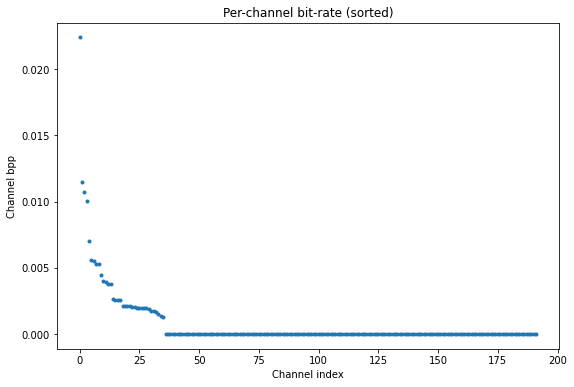

In [ ]:
%matplotlib inline
num_pixels = x.size(2) * x.size(3)

ordered_idxs = torch.argsort(torch.Tensor(channel_bpps), descending=True)
ordered_channel_bpps = torch.Tensor(channel_bpps)[ordered_idxs]

fig, ax = plt.subplots(figsize=(9, 6))
ax.plot(ordered_channel_bpps, '.')
ax.title.set_text('Per-channel bit-rate (sorted)')
ax.set_xlabel('Channel index')
ax.set_ylabel('Channel bpp')
plt.show()

### Interactive per-channel visualization

In [ ]:
from IPython.display import display, clear_output

In [ ]:
%%capture
%matplotlib inline

fig, axes = plt.subplots(1, 2, figsize=(12, 9))
for ax in axes:
    ax.axis('off')

out = widgets.Output()
def show_channel(c):
    channel = y[0, ordered_idxs[c]].cpu()
    axes[0].imshow(channel)
    axes[0].title.set_text(f'Y | min: {channel.min():.2f} | max: {channel.max():.2f}')
    
    channel = y_hat[0, ordered_idxs[c]].cpu()
    axes[1].imshow(channel)
    axes[1].title.set_text(f'Yhat | min: {channel.min():.2f} | max: {channel.max():.2f}')
    with out:
        clear_output(wait=True)
        display(fig)

In [ ]:
slider = widgets.IntSlider(min=0, max=y.size(1)-1, step=1,continuous_update=False, description='Channel idx')
slider.observe(lambda ev: show_channel(slider.value))
show_channel(0)
display(widgets.VBox([out, slider]))

## Quantized vs continuous latent

In [ ]:
with torch.no_grad():
    x_hat_y = net.g_s(y).clamp_(0, 1)
    x_hat_y_hat = net.g_s(y_hat).clamp_(0, 1)

In [ ]:
print('Decoded continuous latent:')
print(f'PSNR: {compute_psnr(x, x_hat_y):.2f}dB')
print(f'MS-SSIM: {compute_msssim(x, x_hat_y):.4f}')
print()
print('Decoded quantized latent:')
print(f'PSNR: {compute_psnr(x, x_hat_y_hat):.2f}dB')
print(f'MS-SSIM: {compute_msssim(x, x_hat_y_hat):.4f}')

Decoded continuous latent:
PSNR: 31.26dB
MS-SSIM: 0.9783

Decoded quantized latent:
PSNR: 30.29dB
MS-SSIM: 0.9726


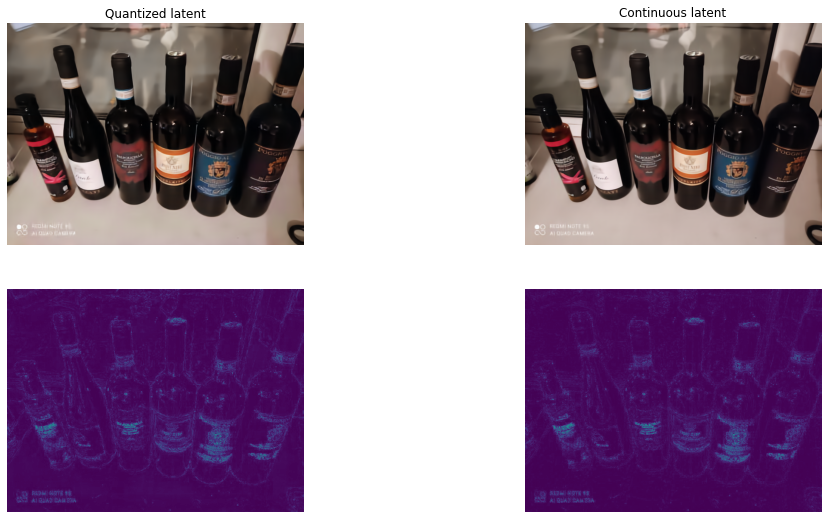

In [ ]:
%matplotlib inline
fig, axes = plt.subplots(2, 2, figsize=(17, 9))
for ax in axes.ravel():
    ax.axis('off')
    
    axes[0][0].imshow(transforms.ToPILImage()(x_hat_y_hat.squeeze().cpu()))
    axes[0][0].title.set_text('Quantized latent')
    
    axes[1][0].imshow(torch.mean((x - x_hat_y_hat).abs(), axis=1).squeeze().cpu())
    
    axes[0][1].imshow(transforms.ToPILImage()(x_hat_y.squeeze()))
    axes[0][1].title.set_text('Continuous latent')
    
    axes[1][1].imshow(torch.mean((x - x_hat_y).abs(), axis=1).squeeze().cpu())

plt.show()